В этом домашнем задании вам предстоит самостоятельно реализовать самые важные компоненты нейросети, **используя только `NumPy`**. 

Ноутбуков в задании много (целых 3), однако большая часть кода написана за вас.😉 Вам предстоит лишь  разобраться в уже написанном коде, понять, как работют некоторые важные компоненты нейронных сетей и написать недстающие строки кода, чтобы все заработало.

Структура задания подразумевает выполнение 3-х `jupyter notebook`'ов.

**`0_train_model.ipynb`**: текущий ноутбук. В нем поясняется суть задания, описаны остальные ноутбуки и именно этот ноутбук нужно запустить, когда все слои уже реализованы.  
**`1_modules.ipynb`**: ноутбук, в котором нужно непосредственно реализовать слои нейронной сети, используя только библиотеку NumPy.  
**`2_research_model.ipynb`**: ноутбук независимый от предыдущих трех, где нужно будет произвести исследование простой нейронной сети.

*Задание на следующей неделе будет похожим на это. Нужно будет реализовть чуть более сложные модули и применить их для создания более продвинутой модели.*

***
## Применение реализованных модулей (55 баллов)
Для начала определим путь до ноутбука с реализованными модулями.

In [7]:
# Путь к папке с заданием
path_to_dir: str = './'
# Путь к файлу с модулями
path_to_modules_notebook = path_to_dir + "1_modules.ipynb"

In [8]:
# В Google Colab подключаемся к диску
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_modules_notebook = "drive/MyDrive/" + path_to_modules_notebook

Следующая ячейка делает `from 1_modules.ipynb import *`, таким образом позволяя этому ноутбуку видеть все модули.

In [9]:
%run $path_to_modules_notebook

test_LeakyReLU (__main__.TestLayers) ... ok
test_Linear (__main__.TestLayers) ... ok
test_LogSoftMax (__main__.TestLayers) ... ok
test_NLLCriterion (__main__.TestLayers) ... ok
test_NLLCriterionUnstable (__main__.TestLayers) ... ok
test_ReLU (__main__.TestLayers) ... ok
test_Sequential (__main__.TestLayers) ... /home/armkilikia/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
ok
test_SoftMax (__main__.TestLayers) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.501s

OK


После того, как все слои в `1_modules.ipynb` протестированы и работают корректно, проверим нейросеть на наборах синтетических данных.

In [10]:
from IPython import display
from itertools import cycle, islice
import time
from time import time, sleep
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from sklearn import cluster, datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import SGD as torch_sgd


cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF3300', '#00CC66'])
RANDOM_SEED = 42

sns.set(font_scale=1.5, palette='Set2')
np.random.seed(RANDOM_SEED)

Будем применять реализованные модули на синтетических данных.

### 1. Линейно разделимая выборка (30 баллов)

Обучим однослойную нейронную сеть решать линейно-разделимую классификацию на 2 класса.

In [11]:
n_samples = 1024
n_classes = 2

varied_blobs = datasets.make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_classes,
    cluster_std=[1.0, 2.5], 
    random_state=RANDOM_SEED
)

sample, labels = varied_blobs

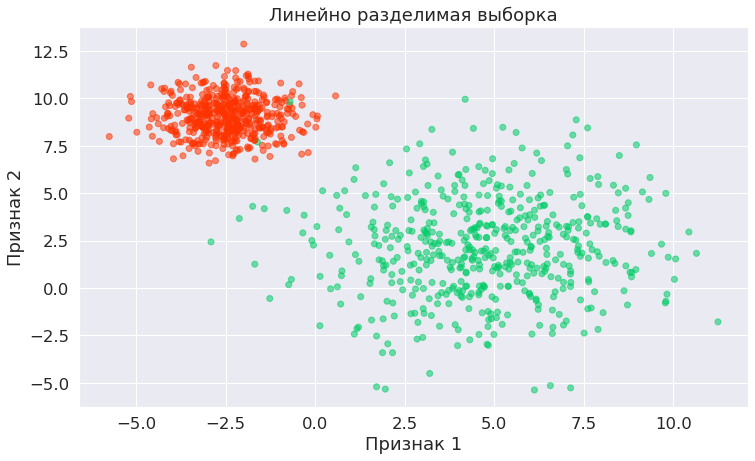

In [12]:
plt.figure(figsize=(12,7))
plt.title('Линейно разделимая выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:,0], sample[:,1], c=labels, cmap=cm_bright, alpha=0.55);

Генератор батчей. Помним, что нейросети обучаются итеративно $-$ по батчам.

In [13]:
def train_generator(sample, labels, batch_size):
    '''
    Генератор батчей. 
    На каждом шаге возвращает `batch_size` объектов из `sample` и их 
    меток из `labels`.
    '''
    n_samples = sample.shape[0]
    # Перемешиваем в случайном порядке в начале эпохи
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Обратите внимание на yield вместо return
    # (если раньше не сталкивались с генераторами)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx], labels[batch_idx]

Функция для удобного обучения модели.

In [14]:
def train_model(
    model, 
    sample, y,
    criterion,
    opt_params, 
    opt_state, 
    n_epoch, 
    batch_size
):
    '''
    Обучает модель из вашего мини-фреймворка. 
    Возвращает обученную модель, историю значений функции потерь 
    и метрики качества.
    
    :param `model`: модель из вашего мини-фреймворка
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `opt_state`: текущая информация о градиентах, 
                        хранящаяся в оптимизаторе
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''
    
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            model.zero_grad_params()
            
            # Forward pass
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            
            # Backward pass
            grad_input = criterion.backward(predictions, y_batch)
            model.backward(x_batch, grad_input)
            
            # Обновление весов
            SGD(model.get_parameters(), 
                model.get_grad_params(), 
                opt_params,
                opt_state)
            loss_history.append(loss)

        display.clear_output(wait=True)
        
        plt.figure(figsize=(8, 6))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.title(f'Loss: {loss:.3f}')
        plt.show()
    
    return model, loss_history

Построим однослойную нейросеть для классификации: размер слоя $2 \times 2$, так как 2 признака и 2 класса. В качестве последнего слоя рекомендуется использовать `LogSoftMax`.

In [15]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 2
LogSoftMax



Объявим оптимизируемую функцию потерь и гиперпаарметры.

In [16]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-2}
optimizer_state = {}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

Проверим, что кодирование производится верно.

In [17]:
y = np.hstack([1-labels[:,None], labels[:,None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[0 1 1 0 1 1 1 1 1 0]
[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


Обучим модель с помощью функции `train_model`.

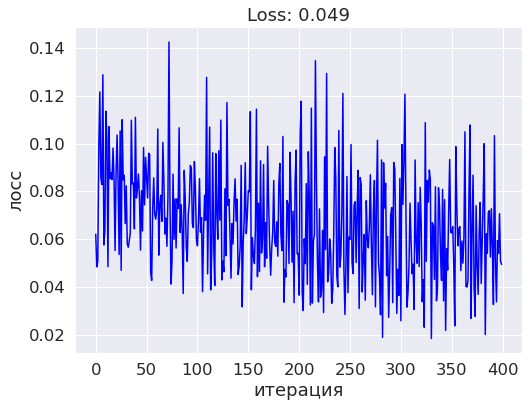

In [18]:
net, loss_history = train_model(
    net, 
    sample, y, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

Поменяйте гиперпараметр `learning_rate` в `optimizer_config` на 1е-1, 1е-2, 1е-3 и 1е-4. 

Как это влияет на обучение?

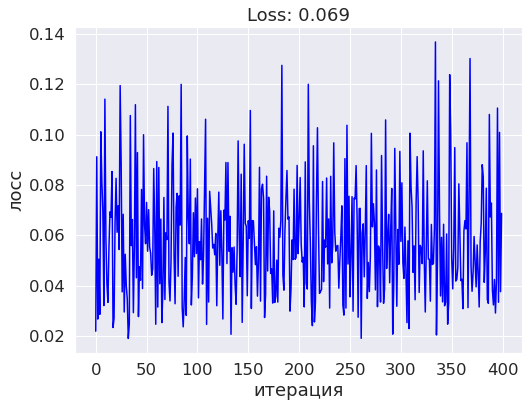

In [19]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-3}
optimizer_state = {}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

net, loss_history = train_model(
    net, 
    sample, y, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

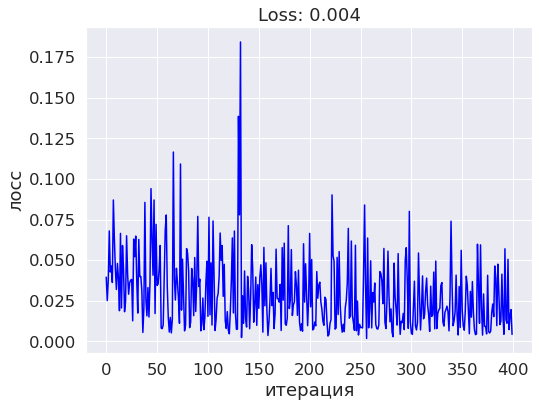

In [22]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1}
optimizer_state = {}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

net, loss_history = train_model(
    net, 
    sample, y, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

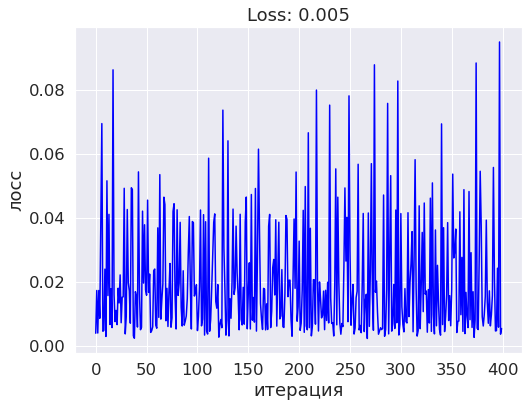

In [23]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-7}
optimizer_state = {}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

net, loss_history = train_model(
    net, 
    sample, y, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

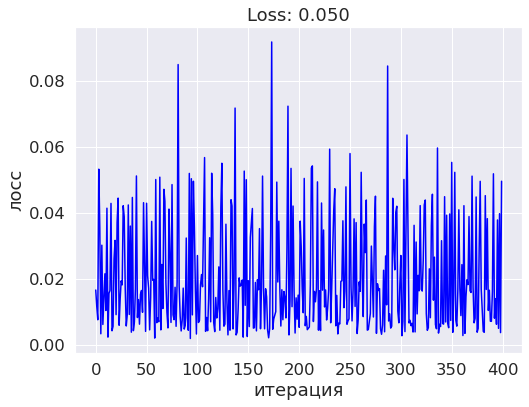

In [24]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-14}
optimizer_state = {}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

net, loss_history = train_model(
    net, 
    sample, y, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

Чем меньше learning_rate, тем лучше. Однако слишком маленьким тоже не нужно брать.

Батч-генератор для тестовой выборки.

In [25]:
def generate_grid(sample, h=0.02):
    '''
    Генерирует двумерную сетку.
    '''
    x_min, x_max = sample[:, 0].min() - .5, sample[:, 0].max() + .5
    y_min, y_max = sample[:, 1].min() - .5, sample[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def test_generator(sample):
    '''
    Батч-генератор для тестовых данных (без меток).
    '''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx]

Функции для удобного тестирования модели.

In [26]:
def test_model(model, test_sample):
    '''
    Тестирует модель на тестовой выборке.
    '''
    preds = []
    for test_batch in test_generator(test_sample):
        batch = model.forward(test_batch)
        batch = batch.argmax(axis=1).reshape(-1,1)
        preds.append(batch)
    preds = np.vstack(preds)
    return preds

In [27]:
def plot_grid_preds(sample, labels, xx, yy, preds, title):
    '''
    Функция для удобной отрисовки предсказаний нейросети на двумерной сетке.
    '''
    plt.figure(figsize=(12,7))
    plt.title(title)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.scatter(sample[:,0], sample[:,1], c=labels, cmap=cm_bright, alpha=0.55)
    plt.contourf(xx, yy, preds, alpha=.2, cmap=cm)
    plt.show();

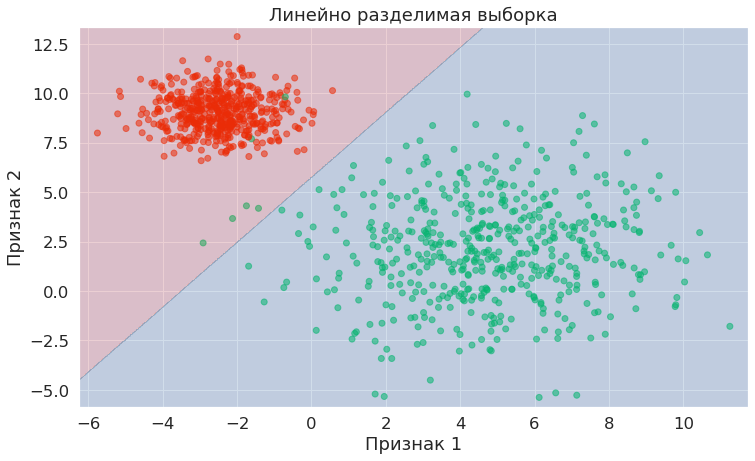

In [28]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)
   
plot_grid_preds(
    sample, 
    labels, 
    xx, yy, 
    test_predictions, 
    'Линейно разделимая выборка'
)

Сравним с точно такой же моделью, но на PyTorch.

*Подсказка.* Названия слоев идентичны, если брать их из `torch.nn`. Отличия только в оптимизаторе и названии функции потерь.

In [29]:
net_torch = nn.Sequential(nn.Linear(2,2),nn.LogSoftmax())

print(net_torch)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LogSoftmax(dim=None)
)


In [31]:
def train_model_torch(
    model, 
    sample, y,
    criterion,
    optimizer,
    n_epoch, 
    batch_size
):
    '''
    Обучает модель из PyTorch. 
    Возвращает обученную модель, историю значений функции потерь 
    и метрики качества.
    
    :param `model`: модель из PyTorch
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `opt_state`: текущая информация о градиентах, 
                        хранящаяся в оптимизаторе
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''
    
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            optimizer.zero_grad()
            # Forward pass
            predictions = model(torch.FloatTensor(x_batch))
            loss = criterion(torch.FloatTensor(predictions), torch.LongTensor(y_batch).argmax(axis=1))
            # Backward pass
            loss.backward()
            # Обновление весов
            optimizer.step()
            
            loss_history.append(loss.data)

        display.clear_output(wait=True)
        
        plt.figure(figsize=(8, 6))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)
    
    return model, loss_history

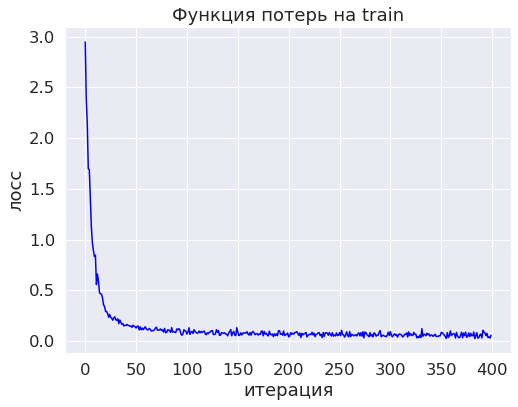

Current loss: 0.056833


In [32]:
criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=1e-2)

net_torch, loss_history = train_model_torch(
    net_torch, sample, y, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

*Для самопроверки.* Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| Linear(2,2) |  1e-2         | 0.1 и ниже |

In [33]:
def test_torch(model, test_sample):
    '''
    Тестирует модель из PyTorch на тестовой выборке.
    '''
    preds = []
    with torch.no_grad():
        for test_batch in test_generator(test_sample):
            preds_batch = model(torch.FloatTensor(test_batch))
            preds_batch = preds_batch.argmax(axis=1).reshape(-1,1)
            preds.append(preds_batch.detach().numpy())
    preds = np.vstack(preds)
    return preds

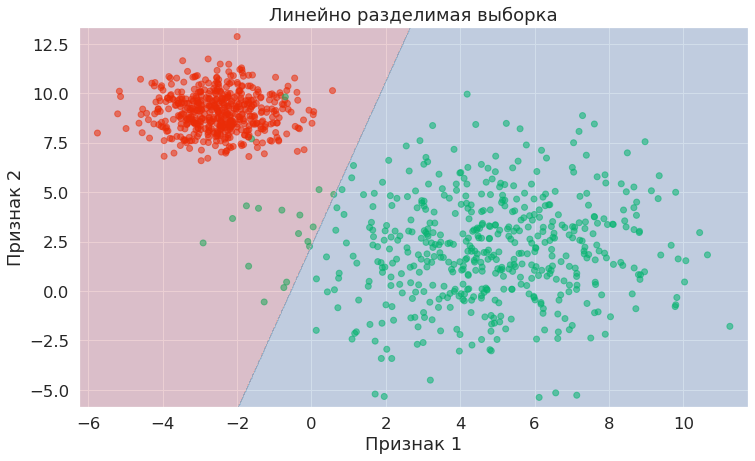

In [34]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_torch(net_torch, test_sample)
test_predictions = test_predictions.reshape(xx.shape)
   
plot_grid_preds(
    sample, 
    labels, 
    xx, yy, 
    test_predictions, 
    'Линейно разделимая выборка'
)

Рисунки с предсказаниями должны практически совпадать у вашей модели и у модели на PyTorch.

### 2. Вложенные окружности (20 баллов)

Проверим работу нейросети на более сложной выборке, которая линейно не разделима в исходном пространстве признаков.

In [35]:
n_samples = 1024

noisy_circles = datasets.make_circles(
    n_samples=n_samples, 
    factor=.5, 
    noise=.05
)

sample, labels = noisy_circles

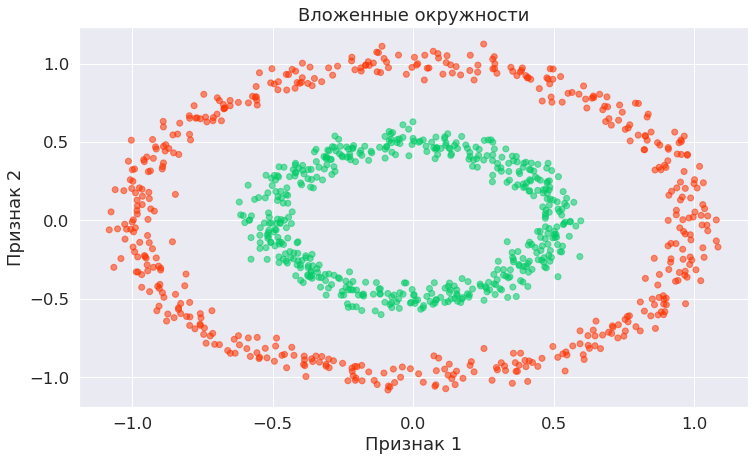

In [36]:
plt.figure(figsize=(12,7))
plt.title('Вложенные окружности')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:,0], sample[:,1], c=labels, cmap=cm_bright, alpha=0.55);

Сначала попробуем обучить и протестировать однослойную неросеть:

In [37]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
print(net)

# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-2}
optimizer_state = {}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

Linear 2 -> 2
LogSoftMax



In [38]:
y = np.hstack([1-labels[:,None], labels[:,None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[0 1 1 0 1 1 0 0 0 1]
[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


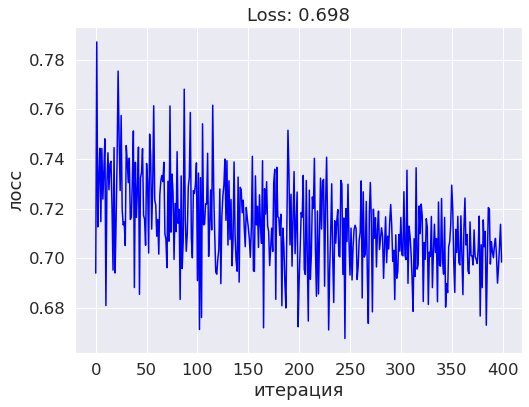

In [39]:
net, loss_history =  train_model(
    net, 
    sample, y, 
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

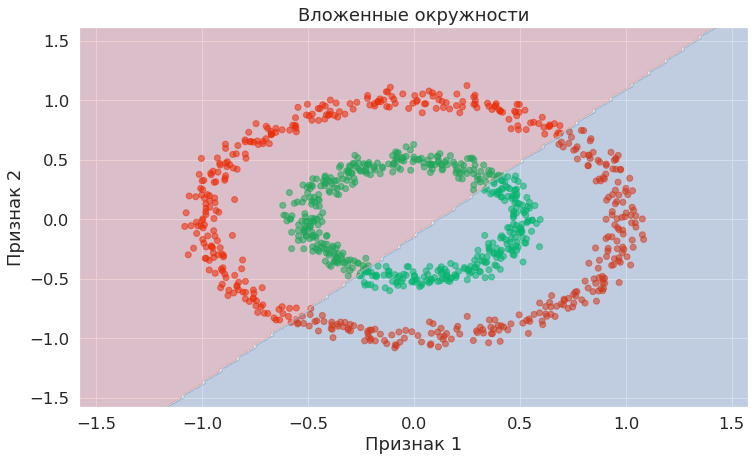

In [40]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, 
                test_predictions, 'Вложенные окружности')

Вряд ли у вас получился лосс ниже 0.68 и адекватный рисунок. Это говорит о том, что один слой не может решить задачу.

Попробуем сделать **двухслойную** нейросеть. Не жалейте нейронов в скрытый слой.

*Подсказка.* Не забудьте про нелинейности.

In [47]:
net = Sequential()
net.add(Linear(2, 300))
net.add(ReLU())
net.add(Linear(300, 2))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()

optimizer_config = {'learning_rate' : 1e-2}
optimizer_state = {}

n_epoch = 100
batch_size = 128

y = np.hstack([1-labels[:,None], labels[:,None]])
print(y.shape)

Linear 2 -> 300
ReLU
Linear 300 -> 2
LogSoftMax

(1024, 2)


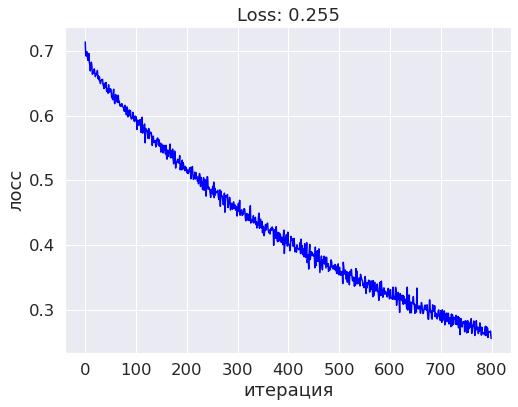

In [48]:
net, loss_history = train_model(
    net, 
    sample, y,
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

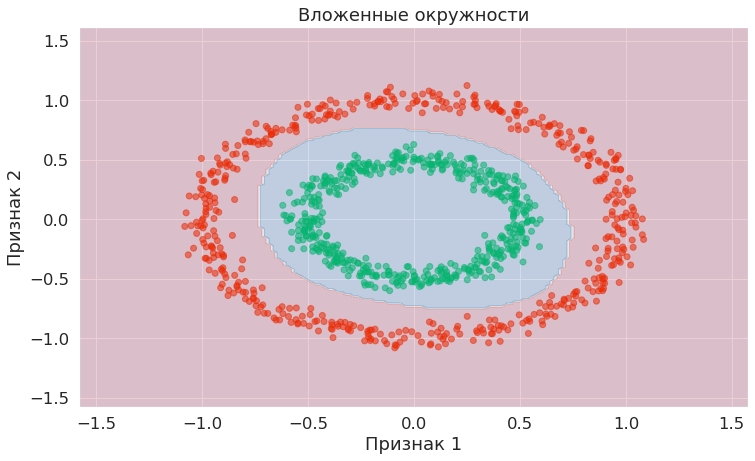

In [49]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

Попробуйте менять количество нейронов в скрытом слое. Начиная с какого количества нейронов окружности начинают хорошо разделяться?

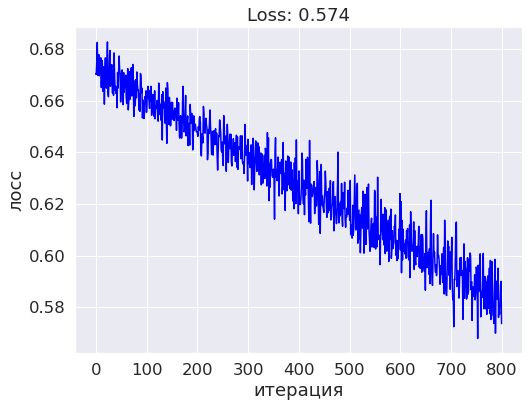

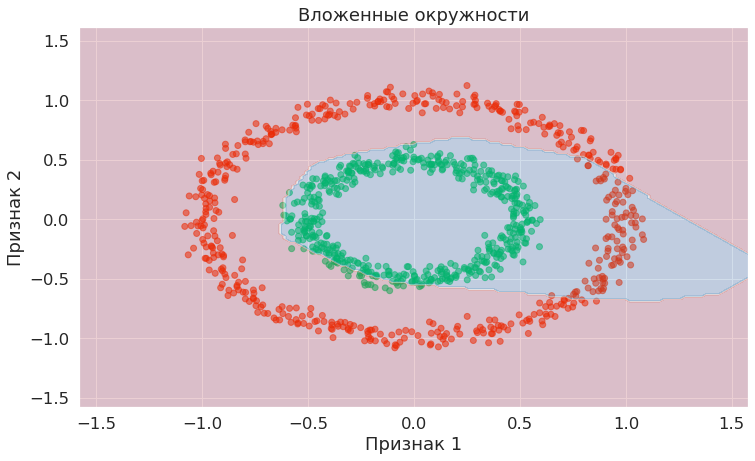

In [72]:
net = Sequential()
net.add(Linear(2, 20))
net.add(ReLU())
net.add(Linear(20, 2))
net.add(LogSoftMax())

net, loss_history = train_model(
    net, 
    sample, y,
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

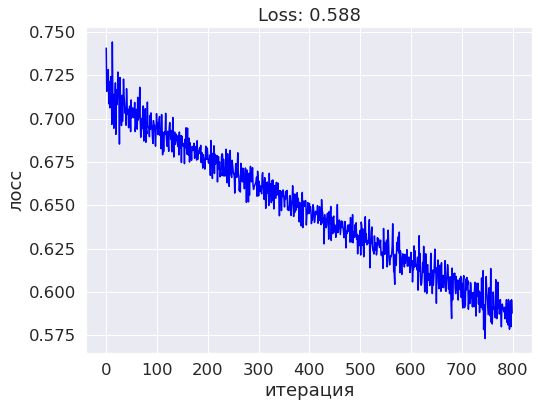

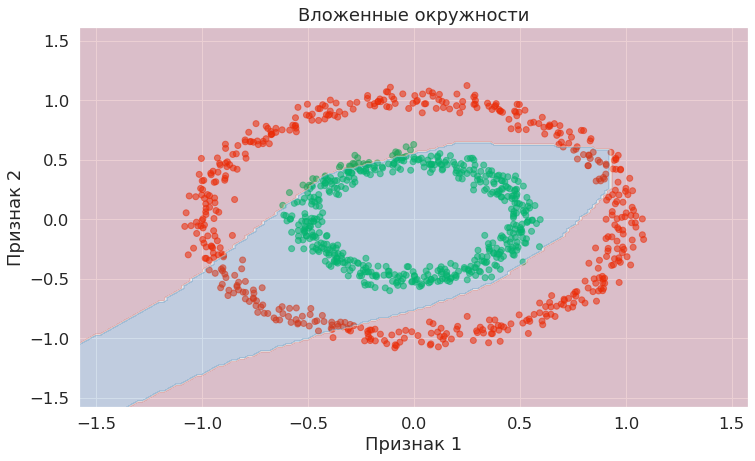

In [74]:
net = Sequential()
net.add(Linear(2, 40))
net.add(ReLU())
net.add(Linear(40, 2))
net.add(LogSoftMax())

net, loss_history = train_model(
    net, 
    sample, y,
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

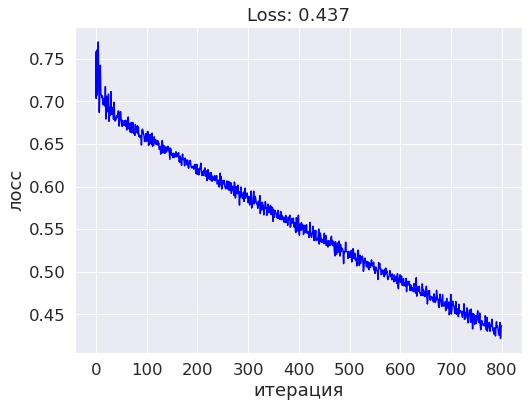

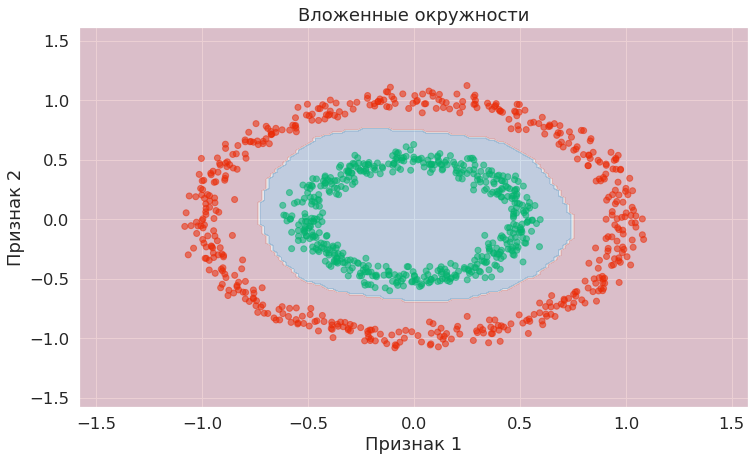

In [75]:
net = Sequential()
net.add(Linear(2, 100))
net.add(ReLU())
net.add(Linear(100, 2))
net.add(LogSoftMax())

net, loss_history = train_model(
    net, 
    sample, y,
    criterion,
    optimizer_config, 
    optimizer_state,
    n_epoch,
    batch_size
)

xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

Ну вроде начиная со 100 получается очень хорошо.

И снова сравним с PyTorch.

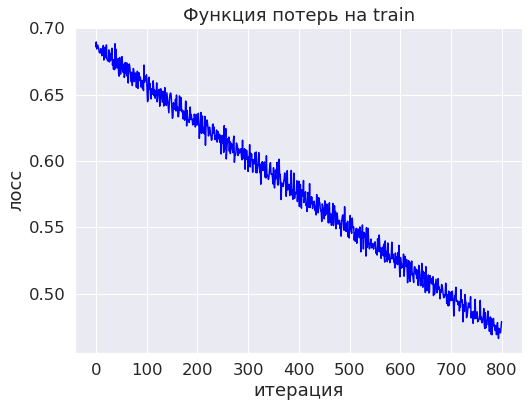

Current loss: 0.478866


In [76]:
net_torch = nn.Sequential(nn.Linear(2,100), nn.ReLU(), nn.Linear(100,2), nn.LogSoftmax())

print(net_torch)

criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=1e-2)

net_torch, loss_history = train_model_torch(
    net_torch, 
    sample, y, 
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

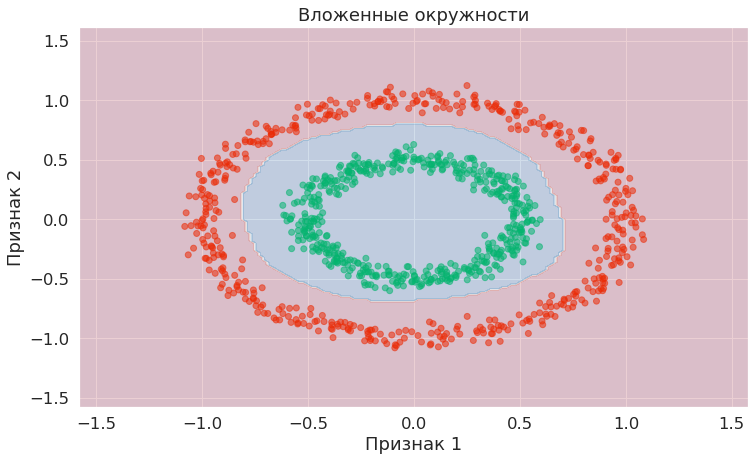

In [77]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_torch(net_torch, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, 
                test_predictions, 'Вложенные окружности')

*Для самопроверки*. Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см. таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| (2,100) -> ReLU -> (100,2) |  1e-2         | 0.45 и ниже |

Оба рисунка должны примерно совпадать и адекватно разделять окружности между собой (одна область должна быть "внутри" другой).